In [1]:
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch

In [2]:
import torchvision
from fastai.vision.all import *

Import the MNIST dataset and create the CNN class

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081))
])
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

Fastai takes the available device by default

In [59]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, CNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.268220,0.125223,0.967600,00:09
1,0.180574,0.076814,0.982200,00:09
2,0.137887,0.058973,0.983900,00:09


Save the model, trained in fastai
By default it is saved in the /models folder with .pth extension

In [60]:
learn.save('./fastai_cnn')

Path('models/fastai_cnn.pth')

Load the model(fastai) and save it as torch model for foolbox compatibility

In [61]:
model_new = learn.load('fastai_cnn')
torch.save(model_new.model.state_dict(), 'fastai_cnn_weights.pth')

Load model for the attack

In [63]:
torched_model = CNet()
torched_model.load_state_dict(torch.load('fastai_cnn_weights.pth'))
torched_model.eval()

CNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Think about preprocess and the attack on the model!!!!!!

In [64]:
#model = torchvision.models.resnet18(pretrained=True).eval()
preprocess = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bound = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bound, preprocessing=preprocess)

In [26]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=10)

In [27]:
fb.utils.accuracy(fmodel, images, labels)

0.8999999761581421

In [28]:
attack = fb.attacks.LinfDeepFoolAttack()

In [29]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

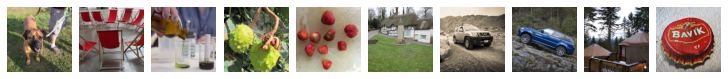

In [30]:
fb.plot.images(images)

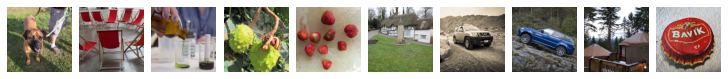

In [31]:
fb.plot.images(raw)

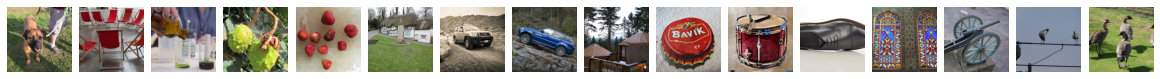

In [18]:
fb.plot.images(clipped)